In [5]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate
import os
from collections import defaultdict
from kagglehub import dataset_download
pd.set_option("display.precision", 1)

In [6]:
# Téléchargement du dataset (remplacez par votre méthode de téléchargement)

# Charger les fichiers séparément
ratings_for_additional_users = pd.read_csv("../data_release/ratings_for_additional_users.csv")
movies = pd.read_csv( "../data_release/movies.csv")
movie_elicitation_set = pd.read_csv( "../data_release/movie_elicitation_set.csv")
belief_data = pd.read_csv( "../data_release/belief_data.csv")
user_rating_history = pd.read_csv( "../data_release/user_rating_history.csv")
user_recommendation_history = pd.read_csv( "../data_release/user_recommendation_history.csv")

print(f"Données chargées:")
print(f"- Movies: {movies.shape}")
print(f"- ratings for additional users: {ratings_for_additional_users.shape}")
print(f"- user rating history: {user_rating_history.shape}")



Données chargées:
- Movies: (105071, 3)
- ratings for additional users: (4185688, 4)
- user rating history: (2046124, 4)


In [7]:
ratings_for_additional_users.head()

,userId,movieId,rating,tstamp
0,393217,1,3.5,2023-01-25 19:45:46
1,393217,6,4.0,2023-02-07 21:17:19
2,393217,16,3.5,2023-01-25 19:50:40
3,393217,17,4.5,2023-01-25 19:49:45
4,393217,32,3.0,2023-01-25 19:46:01


In [8]:
 movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
user_rating_history.head()

,userId,movieId,rating,tstamp
0,42170,1,4.0,1998-06-18 16:31:37
1,42170,7,4.0,1998-06-18 16:31:37
2,42170,17,4.0,1998-06-18 16:31:37
3,42170,24,2.0,1997-11-07 13:41:17
4,42170,36,2.0,1997-11-07 13:27:51


In [10]:
# Extraire l'année avec regex
movies["year"] = movies["title"].str.extract(r"\((\d{4})\)").astype(float)

print("\nFilm le plus ancien :")
print(movies.loc[movies["year"].idxmin()])

print("\nFilm le plus récent :")
print(movies.loc[movies["year"].idxmax()])


Film le plus ancien :
movieId                     148054
title      Passage de Venus (1874)
genres                 Documentary
year                        1874.0
Name: 54503, dtype: object

Film le plus récent :
movieId                  295263
title      Kleks Academy (2024)
genres                  Fantasy
year                     2024.0
Name: 22187, dtype: object


## 3. Préparation et nettoyage des données

In [11]:
min_ratings=20
ratings = pd.concat([user_rating_history, ratings_for_additional_users], ignore_index=True)
ratings = ratings.dropna(subset=['rating'])

In [12]:
# Filtrer les utilisateurs et films avec suffisamment de ratings
movie_counts = ratings['movieId'].value_counts()

valid_movies = movie_counts[movie_counts >= min_ratings].index

filtered_ratings = ratings[
    (ratings['userId']) & 
    (ratings['movieId'].isin(valid_movies))
]

print(f"Données filtrées: {len(filtered_ratings)} ratings")
print(f"Utilisateurs: {filtered_ratings['userId'].nunique()}")
print(f"Films: {filtered_ratings['movieId'].nunique()}")

Données filtrées: 2864752 ratings
Utilisateurs: 8493
Films: 20763


In [13]:
print(ratings.shape)
print(ratings.head())

(6195291, 4)
   userId  movieId  rating               tstamp
0   42170        1     4.0  1998-06-18 16:31:37
1   42170        7     4.0  1998-06-18 16:31:37
2   42170       17     4.0  1998-06-18 16:31:37
3   42170       24     2.0  1997-11-07 13:41:17
4   42170       36     2.0  1997-11-07 13:27:51


In [14]:
# Extraire la liste des genres
genres_list = []
for genres_str in movies['genres']:
    if pd.isna(genres_str) or genres_str == "(no genres listed)":
        continue
    genres_list.extend(genres_str.split('|'))

unique_genres = sorted(list(set(genres_list)))
print(f"Genres disponibles: {unique_genres}")

Genres disponibles: ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [15]:
# Créer des features de genres pour les films
movie_genre_features = pd.DataFrame(index=movies['movieId'])
for genre in unique_genres:
    movie_genre_features[f'genre_{genre}'] = 0

for idx, row in movies.iterrows():
    movie_id = row['movieId']
    if pd.isna(row['genres']) or row['genres'] == "(no genres listed)":
        continue
    genres = row['genres'].split('|')
    for genre in genres:
        if f'genre_{genre}' in movie_genre_features.columns:
            movie_genre_features.loc[movie_id, f'genre_{genre}'] = 1

# === Calcul des statistiques des films ===
movie_stats = filtered_ratings.groupby('movieId').agg({
    'rating': ['mean', 'count']
}).round(2)
movie_stats.columns = ['movie_rating_mean', 'movie_rating_count']

# Ajouter ces stats aux features de films
movie_genre_features = movie_genre_features.join(movie_stats, how='left')
movie_genre_features = movie_genre_features.fillna({'movie_rating_mean': 0, 'movie_rating_count': 0})


In [16]:
movie_genre_features.head()

,genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,...,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,movie_rating_mean,movie_rating_count
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.6,2932.0
2,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.3,1519.0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,2.5,215.0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,2.0,63.0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.4,260.0


In [17]:
# Créer un dictionnaire des films enrichi avec stats
movie_dict = {}
for _, row in movies.iterrows():
    movie_id = row['movieId']
    mean_rating = movie_stats.loc[movie_id, 'movie_rating_mean'] if movie_id in movie_stats.index else 0
    count_rating = movie_stats.loc[movie_id, 'movie_rating_count'] if movie_id in movie_stats.index else 0
    
    movie_dict[movie_id] = {
        'title': row['title'],
        'genres': row['genres'],
        'rating_mean': mean_rating,
        'rating_count': count_rating
    }

In [18]:
movie_dict[1]

{'title': 'Toy Story (1995)',
 'genres': 'Adventure|Animation|Children|Comedy|Fantasy',
 'rating_mean': np.float64(3.62),
 'rating_count': np.int64(2932)}

In [19]:
# Calculer les statistiques utilisateur
user_stats = filtered_ratings.groupby('userId').agg({
    'rating': ['mean', 'count']
}).round(1)
user_stats.columns = ['rating_mean', 'rating_count']

In [20]:
user_stats.head()

,rating_mean,rating_count
userId,,
12559,3.2,691
15893,3.3,11
22005,3.5,1333
41965,3.6,355
42529,3.8,605


In [21]:
# S'assurer que c'est bien en datetime
filtered_ratings = filtered_ratings.copy()
filtered_ratings["tstamp"] = pd.to_datetime(filtered_ratings["tstamp"])

In [22]:
# ==============================
# === Stats pour les UTILISATEURS ===
# ==============================
user_time_diffs = []

for user_id, group in filtered_ratings.groupby("userId"):
    group_sorted = group.sort_values("tstamp")
    if len(group_sorted) > 1:
        deltas = group_sorted["tstamp"].diff().dt.total_seconds().dropna()
        avg_delta = deltas.mean()
    else:
        avg_delta = np.nan
    
    user_time_diffs.append((user_id, avg_delta))

user_time_diffs = pd.DataFrame(user_time_diffs, columns=["userId", "user_avg_time_diff"])

# Ajouter aux stats utilisateurs
user_stats = user_stats.join(user_time_diffs.set_index("userId"), how="left")
user_stats["user_avg_time_diff"] = user_stats["user_avg_time_diff"].fillna(-1)



In [23]:
user_stats.head()

,rating_mean,rating_count,user_avg_time_diff
userId,,,
12559,3.2,691,1.2e+06
15893,3.3,11,4.5e+07
22005,3.5,1333,6.2e+05
41965,3.6,355,2.3e+06
42529,3.8,605,1.4e+06


In [24]:
# Créer des features de préférence de genre par utilisateur
user_genre_prefs = pd.DataFrame(index=user_stats.index)
for genre in unique_genres:
    user_genre_prefs[f'pref_{genre}'] = 0.0

# Calculer les préférences de genre basées sur les ratings
for user_id in user_stats.index:
    user_ratings = filtered_ratings[filtered_ratings['userId'] == user_id]
    genre_ratings = defaultdict(list)
    
    for _, rating_row in user_ratings.iterrows():
        movie_id = rating_row['movieId']
        rating = rating_row['rating']
        
        if movie_id in movie_dict:
            genres_str = movie_dict[movie_id]['genres']
            if pd.notna(genres_str) and genres_str != "(no genres listed)":
                genres = genres_str.split('|')
                for genre in genres:
                    genre_ratings[genre].append(rating)
    
    # Calculer la moyenne des ratings par genre
    for genre in unique_genres:
        if genre in genre_ratings:
            user_genre_prefs.loc[user_id, f'pref_{genre}'] = np.mean(genre_ratings[genre])


In [25]:
user_genre_prefs.head()

,pref_Action,pref_Adventure,pref_Animation,pref_Children,pref_Comedy,pref_Crime,pref_Documentary,pref_Drama,pref_Fantasy,pref_Film-Noir,pref_Horror,pref_IMAX,pref_Musical,pref_Mystery,pref_Romance,pref_Sci-Fi,pref_Thriller,pref_War,pref_Western
userId,,,,,,,,,,,,,,,,,,,
12559,3.1,3.0,2.9,2.9,3.1,3.3,2.7,3.4,2.8,0.0,1.9,4.0,2.3,3.0,3.3,3.3,3.1,2.8,2.7
15893,3.5,3.5,0.0,0.0,2.2,3.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,3.8,5.0,3.6,3.9,0.0,0.0
22005,3.5,3.5,3.5,3.3,3.2,3.5,4.0,3.6,3.4,3.8,3.3,3.8,3.4,3.7,3.4,3.6,3.5,3.9,3.8
41965,3.5,3.6,3.7,3.6,3.6,3.6,3.5,3.8,3.7,0.0,2.0,3.7,3.5,3.8,3.6,3.5,3.6,4.0,3.2
42529,3.8,3.8,3.9,3.9,3.8,3.7,4.2,3.9,3.8,3.6,3.4,3.4,4.0,3.8,3.8,3.8,3.6,4.2,4.1


In [26]:
# ==============================
# === Stats pour les FILMS ===
# ==============================
movie_time_diffs = []

for movie_id, group in filtered_ratings.groupby("movieId"):
    group_sorted = group.sort_values("tstamp")
    if len(group_sorted) > 1:
        deltas = group_sorted["tstamp"].diff().dt.total_seconds().dropna()
        avg_delta = deltas.mean()
    else:
        avg_delta = np.nan  # pas assez de notes
    
    movie_time_diffs.append((movie_id, avg_delta))

movie_time_diffs = pd.DataFrame(movie_time_diffs, columns=["movieId", "movie_avg_time_diff"])

# Ajouter aux features films
movie_genre_features = movie_genre_features.join(movie_time_diffs.set_index("movieId"), how="left")
movie_genre_features["movie_avg_time_diff"] = movie_genre_features["movie_avg_time_diff"].fillna(0)

In [27]:
movie_genre_features.head()

,genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,...,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,movie_rating_mean,movie_rating_count,movie_avg_time_diff
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,3.6,2932.0,2.9e+05
2,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,3.3,1519.0,5.3e+05
3,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,2.5,215.0,3.9e+06
4,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,2.0,63.0,1.2e+07
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,2.4,260.0,3.2e+06


In [28]:
# Ajouter au dictionnaire des films
for movie_id in movie_dict.keys():
    if movie_id in movie_time_diffs.set_index("movieId").index:
        movie_dict[movie_id]["avg_time_diff"] = movie_time_diffs.set_index("movieId").loc[movie_id, "movie_avg_time_diff"]
    else:
        movie_dict[movie_id]["avg_time_diff"] = 0

In [29]:
movie_dict[1]

{'title': 'Toy Story (1995)',
 'genres': 'Adventure|Animation|Children|Comedy|Fantasy',
 'rating_mean': np.float64(3.62),
 'rating_count': np.int64(2932),
 'avg_time_diff': np.float64(286156.3319686114)}

In [30]:
movie_genre_features = movie_genre_features.fillna(0)
user_genre_prefs = user_genre_prefs.fillna(0)


In [31]:
user_stats.head

<bound method NDFrame.head of         rating_mean  rating_count  user_avg_time_diff
userId                                               
12559           3.2           691             1.2e+06
15893           3.3            11             4.5e+07
22005           3.5          1333             6.2e+05
41965           3.6           355             2.3e+06
42529           3.8           605             1.4e+06
...             ...           ...                 ...
410487          3.7           103             1.6e+02
410539          3.9             5             1.8e+01
410545          4.3            26             9.4e+00
410559          4.7             6             3.4e+03
410561          3.8            13             2.2e+01

[8493 rows x 3 columns]>

In [32]:
# Créer les matrices d'entraînement
training_data = []

for _, row in filtered_ratings.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    rating = row['rating']
    
    if user_id in user_stats.index and movie_id in movie_genre_features.index:
        # Features utilisateur
        user_features = [user_id, user_stats.loc[user_id, 'rating_count'], 
                         user_stats.loc[user_id, 'rating_mean'], 
                         user_stats.loc[user_id, 'user_avg_time_diff'] ]
        user_features.extend(user_genre_prefs.loc[user_id].values)
        
        # Features film
        movie_features = [movie_id]
        movie_features.extend(movie_genre_features.loc[movie_id].values)
        
        training_data.append({
            'user_features': user_features,
            'item_features': movie_features,
            'rating': rating
        })


In [33]:
# Convertir en arrays numpy
user_train = np.array([d['user_features'][1:] for d in training_data])
item_train = np.array([d['item_features'][1:] for d in training_data])
y_train = np.array([d['rating'] for d in training_data])
    

In [34]:
print("taille user train", user_train.shape)
print("taille item train", item_train.shape)
print("taille y train", y_train.shape)

taille user train (2864741, 22)
taille item train (2864741, 22)
taille y train (2864741,)


In [35]:
user_train[0]

array([1.58100000e+03, 3.20000000e+00, 5.25628692e+05, 3.10661765e+00,
       3.23800000e+00, 3.40500000e+00, 3.20863309e+00, 3.24132730e+00,
       3.33991228e+00, 3.54310345e+00, 3.29156328e+00, 3.19934641e+00,
       4.02173913e+00, 3.03906250e+00, 3.53030303e+00, 2.96753247e+00,
       3.22058824e+00, 3.20360111e+00, 3.24277457e+00, 3.13261649e+00,
       3.31034483e+00, 3.29629630e+00])

In [36]:
item_train[0]

array([0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.62000000e+00,
       2.93200000e+03, 2.86156332e+05])

In [37]:
y_train[1]

np.float64(2.0)

In [38]:
# Créer les feature names
user_feature_names = ['userId', 'rating_count', 'rating_mean'] + [f'pref_{g}' for g in unique_genres]
item_feature_names = ['movieId'] + [f'genre_{g}' for g in unique_genres]
    

In [39]:
user_feature_names

['userId',
 'rating_count',
 'rating_mean',
 'pref_Action',
 'pref_Adventure',
 'pref_Animation',
 'pref_Children',
 'pref_Comedy',
 'pref_Crime',
 'pref_Documentary',
 'pref_Drama',
 'pref_Fantasy',
 'pref_Film-Noir',
 'pref_Horror',
 'pref_IMAX',
 'pref_Musical',
 'pref_Mystery',
 'pref_Romance',
 'pref_Sci-Fi',
 'pref_Thriller',
 'pref_War',
 'pref_Western']

In [40]:
item_feature_names

['movieId',
 'genre_Action',
 'genre_Adventure',
 'genre_Animation',
 'genre_Children',
 'genre_Comedy',
 'genre_Crime',
 'genre_Documentary',
 'genre_Drama',
 'genre_Fantasy',
 'genre_Film-Noir',
 'genre_Horror',
 'genre_IMAX',
 'genre_Musical',
 'genre_Mystery',
 'genre_Romance',
 'genre_Sci-Fi',
 'genre_Thriller',
 'genre_War',
 'genre_Western']

In [41]:
# Créer item_vecs (tous les films avec leurs features)
item_vecs = []
for movie_id in movie_genre_features.index:
    if movie_id in valid_movies:
        movie_features = movie_genre_features.loc[movie_id].values  # <-- sans movie_id
        item_vecs.append(movie_features)
item_vecs = np.array(item_vecs)


# Créer item_vecs (tous les films avec leurs features) 
item_vecs_finder = [] 
for movie_id in movie_genre_features.index: 
    if movie_id in valid_movies: 
        movie_features = [movie_id] 
        
        movie_features.extend(movie_genre_features.loc[movie_id].values) 
        
        item_vecs_finder.append(movie_features) 
        
item_vecs_finder = np.array(item_vecs_finder)


In [42]:
len(item_vecs[1])

22

In [43]:
# Créer user_to_genre mapping
user_to_genre = {}
for user_id in user_genre_prefs.index:
    user_to_genre[user_id] = user_genre_prefs.loc[user_id].values

In [44]:
user_to_genre[43715]

array([3.10661765, 3.238     , 3.405     , 3.20863309, 3.2413273 ,
       3.33991228, 3.54310345, 3.29156328, 3.19934641, 4.02173913,
       3.0390625 , 3.53030303, 2.96753247, 3.22058824, 3.20360111,
       3.24277457, 3.13261649, 3.31034483, 3.2962963 ])

In [45]:
## 5. Fonctions utilitaires pour l'affichage
def gen_user_vecs(user_vec, num_items):
    """Génère des vecteurs utilisateur répétés pour tous les films"""
    return np.tile(user_vec, (num_items, 1))

def get_user_vecs(uid, user_train_unscaled, item_vecs, user_to_genre):
    """Récupère les vecteurs utilisateur pour un utilisateur donné"""
    # Trouver l'utilisateur dans les données
    user_indices = np.where(user_train_unscaled[:, 0] == uid)[0]
    if len(user_indices) == 0:
        print(f"Utilisateur {uid} non trouvé")
        return None, None
    
    user_data = user_train_unscaled[user_indices[0]]
    user_vecs = gen_user_vecs(user_data.reshape(1, -1), len(item_vecs))
    
    # Créer des y_vecs factices (ratings moyens de l'utilisateur)
    y_vecs = np.full(len(item_vecs), user_data[2])
    
    return user_vecs, y_vecs

def print_pred_movies(y_p, item_vecs, movie_dict, maxcount=10):
    """Affiche les prédictions de films"""
    print(f"\nTop {maxcount} film recommendations:")
    print("Rating | Title")
    print("-" * 50)
    
    for i in range(min(maxcount, len(y_p))):
        movie_id = int(item_vecs[i][0])
        if movie_id in movie_dict:
            print(f"{y_p[i][0]:4.1f}   | {movie_dict[movie_id]['title']}")

def print_existing_user(y_p, y_actual, user_vecs, item_vecs, movie_dict, maxcount=50):
    """Affiche les prédictions pour un utilisateur existant"""
    print(f"\nPrédictions vs ratings réels (top {maxcount}):")
    print("Pred | Actual | Title")
    print("-" * 60)
    
    for i in range(min(maxcount, len(y_p))):
        movie_id = int(item_vecs[i][0])
        if movie_id in movie_dict:
            print(f"{y_p[i][0]:4.1f} | {y_actual[i][0]:4.1f}   | {movie_dict[movie_id]['title']}")

In [46]:
## 6. Normalisation et division des données

# Scale training data
item_train_unscaled = item_train.copy()
user_train_unscaled = user_train.copy()
y_train_unscaled = y_train.copy()

# Normalisation des features des films
scalerItem = StandardScaler()
scalerItem.fit(item_train)
item_train = scalerItem.transform(item_train)

# Normalisation des features des utilisateurs 
scalerUser = StandardScaler() 
scalerUser.fit(user_train) 
user_train = scalerUser.transform(user_train)

# Normalisation des targets (ratings) 
scalerTarget = MinMaxScaler((-1, 1)) 
scalerTarget.fit(y_train.reshape(-1, 1)) 
y_train = scalerTarget.transform(y_train.reshape(-1, 1))

print("Vérification de l'inverse transform:")
print(f"Items: {np.allclose(item_train_unscaled, scalerItem.inverse_transform(item_train))}")
print(f"Users: {np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train))}")

Vérification de l'inverse transform:
Items: True
Users: True


In [47]:
### Division train/test

# Split des données
item_train, item_test = train_test_split(item_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test = train_test_split(y_train, train_size=0.80, shuffle=True, random_state=1)

print(f"Données d'entraînement:")
print(f"- Films: {item_train.shape}")
print(f"- Utilisateurs: {user_train.shape}")
print(f"- Ratings: {y_train.shape}")
print(f"\nDonnées de test:")
print(f"- Films: {item_test.shape}")
print(f"- Utilisateurs: {user_test.shape}")
print(f"- Ratings: {y_test.shape}")

Données d'entraînement:
- Films: (2291792, 22)
- Utilisateurs: (2291792, 22)
- Ratings: (2291792, 1)

Données de test:
- Films: (572949, 22)
- Utilisateurs: (572949, 22)
- Ratings: (572949, 1)


In [48]:
num_user_features = user_train[0].shape[0]
num_item_features = item_train[0].shape[0]


In [49]:
print("\n--- Vérification des NaN/Inf avant normalisation ---")

# Vérification de user_train_unscaled
if np.isnan(user_train_unscaled).any():
    print("ATTENTION: Des valeurs NaN détectées dans user_train_unscaled!")
    # Optionnel: Afficher où se trouvent les NaN
    # nan_indices = np.where(np.isnan(user_train_unscaled))
    # print(f"Indices des NaN dans user_train_unscaled: {nan_indices}")

if np.isinf(user_train_unscaled).any():
    print("ATTENTION: Des valeurs Inf détectées dans user_train_unscaled!")
    # Optionnel: Afficher où se trouvent les Inf
    # inf_indices = np.where(np.isinf(user_train_unscaled))
    # print(f"Indices des Inf dans user_train_unscaled: {inf_indices}")

# Vérification de item_train_unscaled
if np.isnan(item_train_unscaled).any():
    print("ATTENTION: Des valeurs NaN détectées dans item_train_unscaled!")

if np.isinf(item_train_unscaled).any():
    print("ATTENTION: Des valeurs Inf détectées dans item_train_unscaled!")

# Vérification de y_train_unscaled
if np.isnan(y_train_unscaled).any():
    print("ATTENTION: Des valeurs NaN détectées dans y_train_unscaled!")

if np.isinf(y_train_unscaled).any():
    print("ATTENTION: Des valeurs Inf détectées dans y_train_unscaled!")

print("--- Fin de la vérification des NaN/Inf ---\n")

# Si des NaN/Inf sont trouvés, vous pourriez vouloir ajouter ici du code pour les gérer,
# par exemple en les remplaçant par la moyenne/médiane ou en supprimant les lignes/colonnes affectées.
# Pour l'instant, cela vous alertera simplement de leur présence.


--- Vérification des NaN/Inf avant normalisation ---
--- Fin de la vérification des NaN/Inf ---



In [50]:
## 7. Construction du modèle de recommandation
from keras.layers import Lambda, BatchNormalization, Activation, Dropout, Concatenate, Dense
from keras.regularizers import l2

num_outputs = 64  # un peu plus large pour capturer plus d'infos

# Réseau utilisateur
user_NN = keras.models.Sequential([
    Dense(256, kernel_regularizer=l2(1e-6), name='user_dense_1'),
    BatchNormalization(name='user_bn_1'),
    Activation('gelu', name='user_act_1'),
    Dropout(0.3),

    Dense(128, kernel_regularizer=l2(1e-6), name='user_dense_2'),
    BatchNormalization(name='user_bn_2'),
    Activation('gelu', name='user_act_2'),
    Dropout(0.3),

    Dense(num_outputs, name='user_dense_3'),
], name='user_model')

# Réseau item
item_NN = keras.models.Sequential([
    Dense(256, kernel_regularizer=l2(1e-6), name='item_dense_1'),
    BatchNormalization(name='item_bn_1'),
    Activation('gelu', name='item_act_1'),
    Dropout(0.3),

    Dense(128, kernel_regularizer=l2(1e-6), name='item_dense_2'),
    BatchNormalization(name='item_bn_2'),
    Activation('gelu', name='item_act_2'),
    Dropout(0.3),

    Dense(num_outputs, name='item_dense_3'),
], name='item_model')


# === Fonctions à déclarer en haut ===
def l2_norm(x):
    return tf.linalg.l2_normalize(x, axis=1)

def diff_abs(x):
    return tf.abs(x[0] - x[1])

def prod_mul(x):
    return x[0] * x[1]



# Inputs
input_user = keras.layers.Input(shape=(num_user_features,))
vu = user_NN(input_user)
vu = Lambda(l2_norm, name="lambda_l2_user")(vu)

input_item = keras.layers.Input(shape=(num_item_features,))
vm = item_NN(input_item)
vm = Lambda(l2_norm, name="lambda_l2_item")(vm)

# Fusion enrichie
from keras.layers import Lambda

diff = Lambda(diff_abs, name="lambda_diff")([vu, vm])
prod = Lambda(prod_mul, name="lambda_prod")([vu, vm])


concat = Concatenate()([vu, vm, diff, prod])

x = Dense(128, activation="gelu")(concat)
x = Dropout(0.3)(x)
x = Dense(64, activation="gelu")(x)
output = Dense(1, activation="linear")(x)

# Modèle
model = keras.Model([input_user, input_item], output)
model.compile(optimizer=keras.optimizers.AdamW(1e-3), loss="mse", metrics=["mae"])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_model          │ (None, 64)        │     48,576 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_model          │ (None, 64)        │     48,576 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_l2_user      │ (None, 64)        │          0 │ user_model[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_l2_item      │ (None, 64)        │          0 │ item_model[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_diff         │ (None, 64)        │          0 │ lambda_l2_user[0… │
│ (Lambda)            │                   │            │ lambda_l2_item[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_prod         │ (None, 64)        │          0 │ lambda_l2_user[0… │
│ (Lambda)            │                   │            │ lambda_l2_item[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ lambda_l2_user[0… │
│ (Concatenate)       │                   │            │ lambda_l2_item[0… │
│                     │                   │            │ lambda_diff[0][0… │
│                     │                   │            │ lambda_prod[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 138,369 (540.50 KB)

 Trainable params: 136,833 (534.50 KB)

 Non-trainable params: 1,536 (6.00 KB)

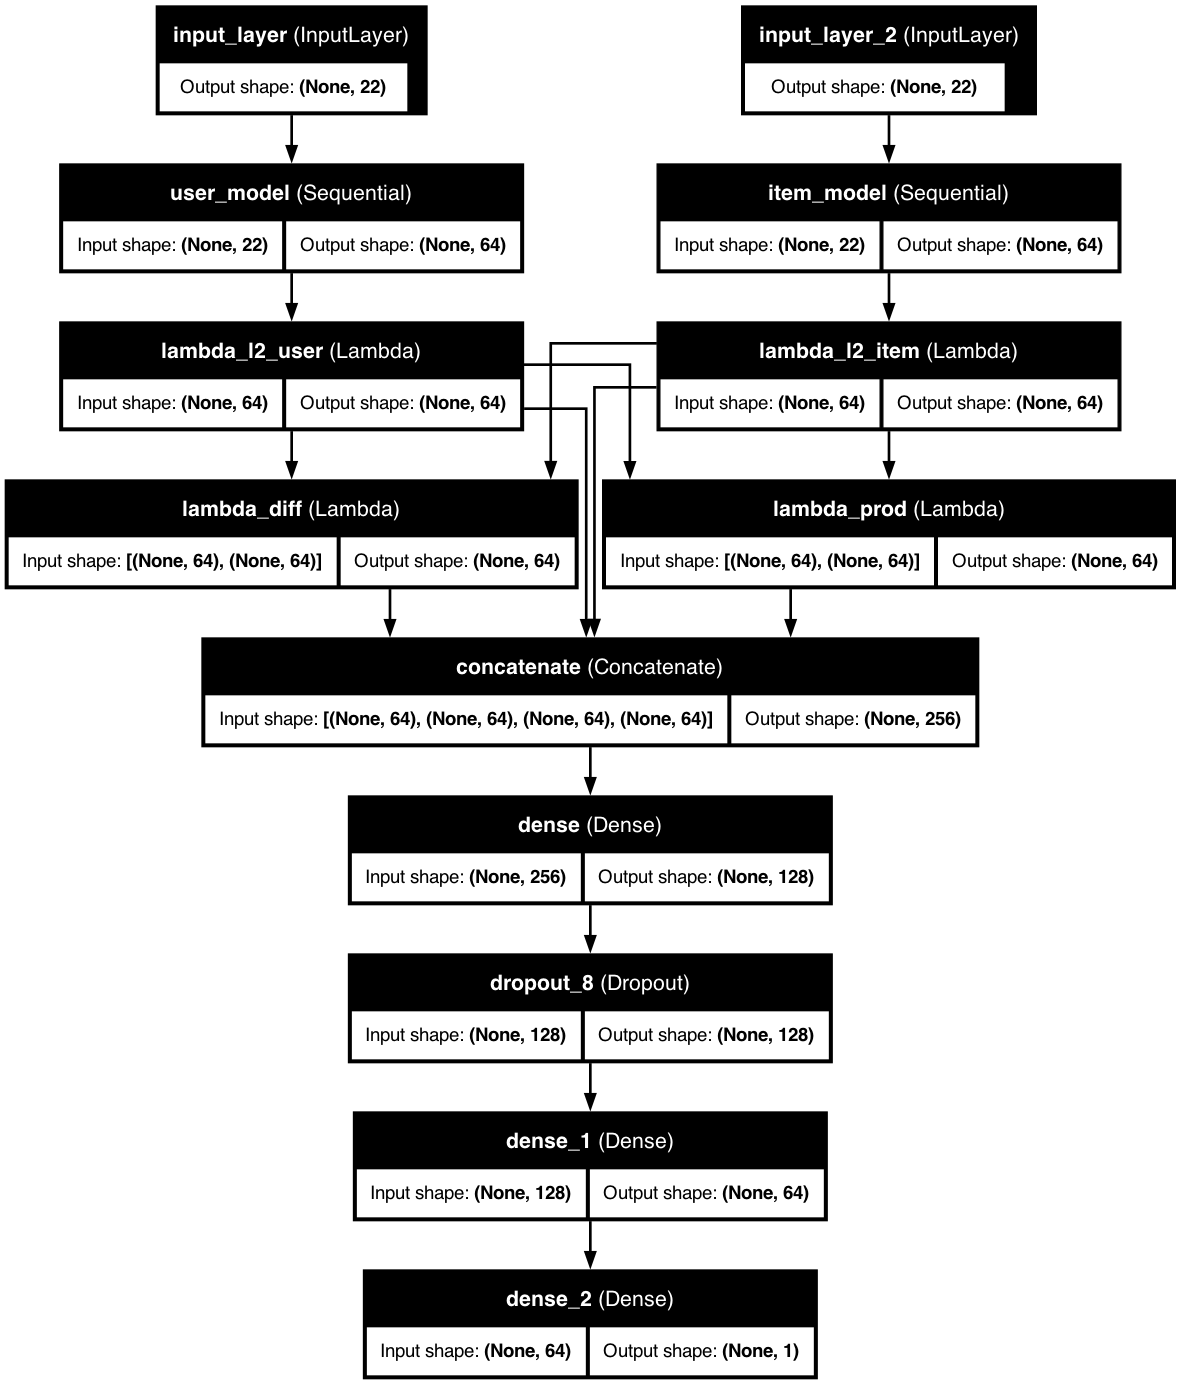

In [55]:
from keras.utils import plot_model
plot_model(model, to_file='./templates/assets/film/architecture_model.png', show_shapes=True, show_layer_names=True, dpi=96)

In [52]:
user_train[0]

array([-0.38672426,  0.6189024 ,  0.84799085,  0.49898445,  0.50850514,
        0.73332463,  0.63088685,  0.48114943,  0.64537783,  0.89026513,
        0.5963531 ,  0.67773152,  0.71511834,  0.5052038 ,  0.54105438,
        0.28724778,  0.51685059,  0.46809024,  0.49489872,  0.50004622,
        0.62905933,  0.94566887])

In [53]:
item_train[0]

array([-0.64614908, -0.54472063, -0.31048497, -0.30236449, -0.69626883,
       -0.43320848, -0.15813623, -0.87227772, -0.36944967, -0.09333986,
        3.11427575, -0.24353984, -0.16533622, -0.30655416, -0.40236441,
       -0.4814288 ,  1.66095384, -0.21228558, -0.12545587, -0.67216089,
       -0.52784476, -0.24833606])

In [54]:
### Lancement de l'entraînement

("🚀 Début de l'entraînement...")
tf.random.set_seed(1)

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("🚀 Début de l'entraînement...")

# Callbacks
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,           # arrête si pas d’amélioration après 3 epochs
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    "./templates/assets/film/best_model.keras",
    monitor="val_loss",
    save_best_only=True
)

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3)

model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# Entraînement
history = model.fit(
    [user_train, item_train],
    y_train,
    epochs=40,
    batch_size=512,   # plus efficace sur gros dataset
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

print("✅ Entraînement terminé !")


🚀 Début de l'entraînement...
Epoch 1/40
 521/4029 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - loss: 0.1747 - mae: 0.3062

KeyboardInterrupt: 

In [ ]:
# Évaluation
test_results = model.evaluate([user_test, item_test], y_test, verbose=0)

# Dépacke les valeurs
test_loss, test_mae = test_results  

print("\n📊 Performance du modèle:")
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"RMSE: {np.sqrt(test_loss):.4f}")
print(f"MAE: {test_mae:.4f}")



📊 Performance du modèle:
Test Loss (MSE): 0.1238
RMSE: 0.3519
MAE: 0.2486


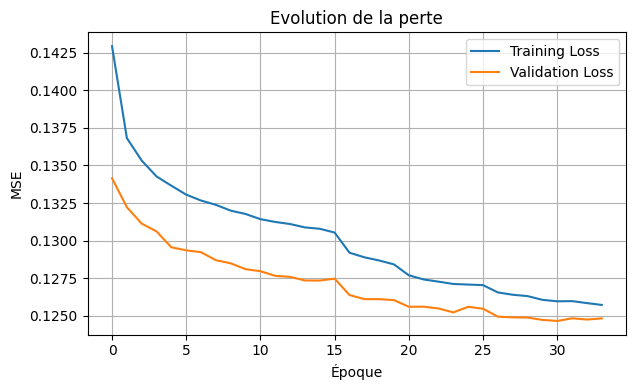

In [ ]:
### Visualisation de l'entraînement

import matplotlib.pyplot as plt

# Graphique des pertes d'entraînement
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolution de la perte')
plt.xlabel('Époque')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
model = tf.keras.models.load_model(
    "./templates/assets/film/best_model.keras",
    custom_objects={
        'l2_norm': l2_norm,
        'diff_abs': diff_abs,
        'prod_mul': prod_mul
    },
    safe_mode=False
)


In [ ]:
## 9. Recommandations pour un nouvel utilisateur


print("🎬 RECOMMANDATIONS POUR UN NOUVEL UTILISATEUR")
print("=" * 60)

# Créer un profil de nouvel utilisateur (amateur d'aventure et de fantasy)
new_rating_ave = 3.5
new_rating_count = 10
new_second_ave = 1570785.7965635739

# Créer le vecteur utilisateur (préférences par genre)
user_prefs = {}
print(unique_genres)
for genre in unique_genres:
    if genre in ['Adventure', 'Fantasy', 'Action']:
        user_prefs[f'pref_{genre}'] = 4.5  # Forte préférence
    elif genre in ['Romance', 'Comedy']:
        user_prefs[f'pref_{genre}'] = 2.0  # Faible préférence
    else:
        user_prefs[f'pref_{genre}'] = 3.0  # Préférence neutre

print("Profil utilisateur créé:")
print(f"- Rating moyen: {new_rating_ave}")
print(f"- Nombre de ratings: {new_rating_count}")
print("- Préférences fortes: Adventure, Fantasy, Action")
print("- Préférences faibles: Romance, Comedy")

user_vec = np.array([[new_rating_count, new_rating_ave, new_second_ave] + 
                    [user_prefs[f'pref_{genre}'] for genre in unique_genres]])

print( len(item_vecs[0]))
print( len(user_vec[0]))
print( len(unique_genres))
print(len(item_vecs))
# Générer les vecteurs utilisateur pour tous les films
user_vecs = gen_user_vecs(user_vec, len(item_vecs))

# Normaliser les données
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# Faire les prédictions
y_p = model.predict([suser_vecs, sitem_vecs])

# Dénormaliser les prédictions
y_pu = scalerTarget.inverse_transform(y_p)

# Trier les résultats
sorted_index = np.argsort(-y_pu, axis=0).reshape(-1).tolist()
sorted_ypu = y_pu[sorted_index]
sorted_items = item_vecs_finder[sorted_index]

print_pred_movies(sorted_ypu, sorted_items, movie_dict, maxcount=15)



🎬 RECOMMANDATIONS POUR UN NOUVEL UTILISATEUR
['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
Profil utilisateur créé:
- Rating moyen: 3.5
- Nombre de ratings: 10
- Préférences fortes: Adventure, Fantasy, Action
- Préférences faibles: Romance, Comedy
22
22
19
20762
 61/649 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step  

/opt/anaconda3/envs/recommendationFilm/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer', 'input_layer_2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


649/649 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step

Top 15 film recommendations:
Rating | Title
--------------------------------------------------
 4.1   | Lord of the Rings: The Return of the King, The (2003)
 4.1   | Lord of the Rings: The Two Towers, The (2002)
 4.1   | Lord of the Rings: The Fellowship of the Ring, The (2001)
 4.1   | Planet Earth II (2016)
 4.1   | Spider-Man: No Way Home (2021)
 4.1   | Star Wars: Episode V - The Empire Strikes Back (1980)
 4.1   | Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
 4.1   | Rogue One: A Star Wars Story (2016)
 4.1   | Untitled Spider-Man Reboot (2017)
 4.1   | Indiana Jones and the Temple of Doom (1984)
 4.1   | Blue Planet II (2017)
 4.1   | The Blue Planet (2001)
 4.1   | Indiana Jones and the Last Crusade (1989)
 4.1   | Dune: Part Two (2024)
 4.1   | Guardians of the Galaxy (2014)


In [ ]:
## 10. Recommandations pour un utilisateur existant

print("👤 RECOMMANDATIONS POUR UN UTILISATEUR EXISTANT")
print("=" * 60)

# Choisir un utilisateur existant
uid = int(user_train_unscaled[100, 0])  # Prendre le 100e utilisateur
print(f"Analyse des recommandations pour l'utilisateur {uid}")

# Obtenir les vecteurs utilisateur
user_vecs, y_vecs = get_user_vecs(uid, user_train_unscaled, item_vecs, user_to_genre)

if user_vecs is not None:
    # Afficher le profil de l'utilisateur
    user_profile = user_train_unscaled[user_train_unscaled[:, 0] == uid][0]
    print(f"Profil utilisateur {uid}:")
    print(f"- Rating moyen: {user_profile[2]:.2f}")
    print(f"- Nombre de ratings: {int(user_profile[1])}")
    
    # Normaliser les données
    suser_vecs = scalerUser.transform(user_vecs)
    sitem_vecs = scalerItem.transform(item_vecs)
    
    # Faire les prédictions
    y_p = model.predict([suser_vecs, sitem_vecs])
    
    # Dénormaliser les prédictions
    y_pu = scalerTarget.inverse_transform(y_p)
    
    # Trier les résultats
    sorted_index = np.argsort(-y_pu, axis=0).reshape(-1).tolist()
    sorted_ypu = y_pu[sorted_index]
    sorted_items = item_vecs_finder[sorted_index]
    sorted_user = user_vecs[sorted_index]
    sorted_y = y_vecs[sorted_index]
    
    print_existing_user(sorted_ypu, sorted_y.reshape(-1,1), sorted_user, 
                       sorted_items, movie_dict, maxcount=25)

👤 RECOMMANDATIONS POUR UN UTILISATEUR EXISTANT
Analyse des recommandations pour l'utilisateur 1581
Profil utilisateur 1581:
- Rating moyen: 525628.69
- Nombre de ratings: 3
649/649 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step

Prédictions vs ratings réels (top 25):
Pred | Actual | Title
------------------------------------------------------------
 4.1 | 525628.7   | Dark Knight, The (2008)
 4.1 | 525628.7   | Shawshank Redemption, The (1994)
 4.1 | 525628.7   | Inception (2010)
 4.0 | 525628.7   | Matrix, The (1999)
 4.0 | 525628.7   | Fight Club (1999)
 4.0 | 525628.7   | Interstellar (2014)
 4.0 | 525628.7   | Lord of the Rings: The Fellowship of the Ring, The (2001)
 4.0 | 525628.7   | Pulp Fiction (1994)
 4.0 | 525628.7   | Lord of the Rings: The Two Towers, The (2002)
 3.9 | 525628.7   | Lord of the Rings: The Return of the King, The (2003)
 3.9 | 525628.7   | Arrival (2016)
 3.9 | 525628.7   | Parasite (2019)
 3.9 | 525628.7   | Truman Show, The (1998)
 3.9 | 525628.7   | Dark Knight Rises

In [ ]:
## 11. Analyse de similarité des films

print("🎭 ANALYSE DE SIMILARITÉ DES FILMS")
print("=" * 60)

def sq_dist(a, b):
    """Calcule la distance euclidienne au carré entre deux vecteurs"""
    return np.sum((b - a) ** 2)

# Test de la fonction de distance
a1 = np.array([1.0, 2.0, 3.0]); b1 = np.array([1.0, 2.0, 3.0])
a2 = np.array([1.1, 2.1, 3.1]); b2 = np.array([1.0, 2.0, 3.0])
a3 = np.array([0, 1, 0]); b3 = np.array([1, 0, 0])

print("Tests de la fonction de distance:")
print(f"Distance entre vecteurs identiques: {sq_dist(a1, b1):.3f}")
print(f"Distance entre vecteurs similaires: {sq_dist(a2, b2):.3f}")
print(f"Distance entre vecteurs différents: {sq_dist(a3, b3):.3f}")


🎭 ANALYSE DE SIMILARITÉ DES FILMS
Tests de la fonction de distance:
Distance entre vecteurs identiques: 0.000
Distance entre vecteurs similaires: 0.030
Distance entre vecteurs différents: 2.000


In [ ]:
### Extraction des embeddings des films

# Créer un modèle pour extraire les embeddings des films
input_item_m = tf.keras.layers.Input(shape=(num_item_features,))
vm_m = item_NN(input_item_m)
vm = Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1))(vm_m)
model_m = tf.keras.Model(input_item_m, vm)
model_m.summary()

# Obtenir les embeddings de tous les films
scaled_item_vecs = scalerItem.transform(item_vecs)
vms = model_m.predict(scaled_item_vecs)
print(f"Taille des vecteurs de features des films: {vms.shape}")



Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_model (Sequential)         │ (None, 64)             │        48,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 64)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,576 (189.75 KB)

 Trainable params: 47,808 (186.75 KB)

 Non-trainable params: 768 (3.00 KB)

649/649 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
Taille des vecteurs de features des films: (20762, 64)


In [ ]:
### Calcul et affichage des similarités

# Calculer les distances entre films
count = 100  # nombre de films à analyser pour les similarités
dim = len(vms)
dist = np.zeros((dim, dim))

print("Calcul des distances entre films...")
for i in range(min(count, dim)):
    for j in range(dim):
        dist[i, j] = sq_dist(vms[i, :], vms[j, :])

# Masquer la diagonale
m_dist = ma.masked_array(dist[:count, :], mask=np.zeros((count, dim)))
np.fill_diagonal(m_dist.mask, True)

# Afficher les films les plus similaires
print(f"\nFilms les plus similaires (analyse sur {min(count, dim)} films):")
print("=" * 100)
print(f"{'Film Original':<40} {'Genres':<25} {'Film Similaire':<40} {'Genres'}")
print("=" * 100)

similar_pairs = []
for i in range(min(count, 25)):  # Limiter l'affichage à 25 paires
    if i < len(m_dist):
        min_idx = np.argmin(m_dist[i])
        movie1_id = int(item_vecs_finder[i, 0])
        movie2_id = int(item_vecs_finder[min_idx, 0])
        
        if movie1_id in movie_dict and movie2_id in movie_dict:
            movie1_title = movie_dict[movie1_id]['title']
            movie2_title = movie_dict[movie2_id]['title']
            movie1_genres = movie_dict[movie1_id]['genres']
            movie2_genres = movie_dict[movie2_id]['genres']
            
            # Tronquer les titres si trop longs
            movie1_display = movie1_title[:37] + "..." if len(movie1_title) > 40 else movie1_title
            movie2_display = movie2_title[:37] + "..." if len(movie2_title) > 40 else movie2_title
            movie1_genres_display = movie1_genres[:22] + "..." if len(movie1_genres) > 25 else movie1_genres
            movie2_genres_display = movie2_genres[:22] + "..." if len(movie2_genres) > 25 else movie2_genres
            
            print(f"{movie1_display:<40} {movie1_genres_display:<25} {movie2_display:<40} {movie2_genres_display}")
            
            similar_pairs.append({
                'movie1': movie1_title,
                'movie2': movie2_title,
                'genres1': movie1_genres,
                'genres2': movie2_genres,
                'distance': dist[i, min_idx]
            })

print("=" * 100)

Calcul des distances entre films...

Films les plus similaires (analyse sur 100 films):
Film Original                            Genres                    Film Similaire                           Genres
Toy Story (1995)                         Adventure|Animation|Ch... Monsters, Inc. (2001)                    Adventure|Animation|Ch...
Jumanji (1995)                           Adventure|Children|Fan... Chronicles of Narnia: The Lion, the W... Adventure|Children|Fan...
Grumpier Old Men (1995)                  Comedy|Romance            Truth About Cats & Dogs, The (1996)      Comedy|Romance
Waiting to Exhale (1995)                 Comedy|Drama|Romance      Summer Catch (2001)                      Comedy|Drama|Romance
Father of the Bride Part II (1995)       Comedy                    Deuce Bigalow: Male Gigolo (1999)        Comedy
Heat (1995)                              Action|Crime|Thriller     The Gentlemen (2020)                     Action|Crime
Sabrina (1995)                           

In [ ]:
## 12. Analyse des résultats et métriques

print("📈 ANALYSE DES RÉSULTATS")
print("=" * 60)

# Statistiques sur les données
print("Statistiques des données d'entraînement:")
print(f"- Nombre total de ratings: {len(y_train_unscaled):,}")
print(f"- Rating moyen: {np.mean(y_train_unscaled):.2f}")
print(f"- Écart-type des ratings: {np.std(y_train_unscaled):.2f}")
print(f"- Rating minimum: {np.min(y_train_unscaled):.1f}")
print(f"- Rating maximum: {np.max(y_train_unscaled):.1f}")

# Distribution des genres
print(f"\nStatistiques des genres ({len(genres)} genres uniques):")
genre_counts = {}
for movie_id, movie_info in movie_dict.items():
    genres_val = movie_info.get('genres')
    if isinstance(genres_val, str) and genres_val != "(no genres listed)":
        for genre in genres_val.split('|'):
            genre_counts[genre] = genre_counts.get(genre, 0) + 1


top_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 des genres les plus fréquents:")
for genre, count in top_genres:
    print(f"- {genre}: {count:,} films")


📈 ANALYSE DES RÉSULTATS
Statistiques des données d'entraînement:
- Nombre total de ratings: 2,864,741
- Rating moyen: 3.13
- Écart-type des ratings: 1.54
- Rating minimum: -1.0
- Rating maximum: 5.0

Statistiques des genres (3 genres uniques):
Top 10 des genres les plus fréquents:
- Drama: 40,363 films
- Comedy: 27,140 films
- Thriller: 14,049 films
- Romance: 12,034 films
- Action: 11,454 films
- Documentary: 11,453 films
- Horror: 10,461 films
- Crime: 8,266 films
- Adventure: 6,358 films
- Sci-Fi: 5,693 films


In [ ]:
import pickle

# Exemple : sauvegarder les objets
with open('./templates/assets/film/scalerUser.pkl', 'wb') as f:
    pickle.dump(scalerUser, f)

with open('./templates/assets/film/scalerItem.pkl', 'wb') as f:
    pickle.dump(scalerItem, f)

with open('./templates/assets/film/scalerTarget.pkl', 'wb') as f:
    pickle.dump(scalerTarget, f)

with open('./templates/assets/film/movie_dict.pkl', 'wb') as f:
    pickle.dump(movie_dict, f)

with open('./templates/assets/film/item_vecs_finder.pkl', 'wb') as f:
    pickle.dump(item_vecs_finder, f)

with open('./templates/assets/film/unique_genres.pkl', 'wb') as f:
    pickle.dump(unique_genres, f)

